# packages

rajouter toutes les librairies au début du colab

In [ ]:
import sqlite3
import random
import numpy as np

In [ ]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# sql

executer ce code pr etablirre une connection entre sqlite et python il suffira après d'ecrire votre requetes sous forme d'str qui va etre transformé en dataframe comme l'exemple ci dessous

In [ ]:

r = requests.get('https://raw.githubusercontent.com/murpi/wilddata/master/quests/toys_and_models.sqlite')
open('toys_and_models.sqlite', 'wb').write(r.content)

307200

In [ ]:
# This part is common : we have to initiate a connection between Python and the SQL Database


# This is the "connector". For secured database, it will be here that  you indicate your username and password.
conn = sqlite3.connect('toys_and_models.sqlite')

In [ ]:
#voici le schema de la db

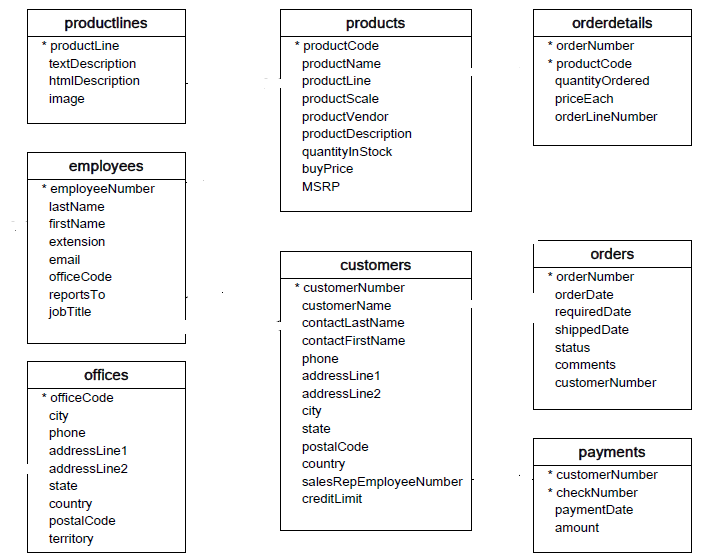

tips pr afficher le contenu des differentes tables

In [ ]:
for c in ['productlines', 'employees', 'offices', 'customers', 'orders', 'payments', 'orderdetails', 'products']:
    r = f"""
        select * from {c} limit 10
        """
    df = pd.read_sql(r, conn)

    print(f"###################################### {c} ###############################################")
    print(df.to_markdown())
    print("\n\n\n")

###################################### productlines ###############################################
|    | productLine      | textDescription                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | htmlDescription   | image   |
|---:|:-----------------|:--------------------------------------------------------------------------------

### q1

trouver les relations entre les tables. bien identifier la clé primaire et la clé secondaire et le type de lien (one to many ou many to many)

ex :

un client peux avoir plusieur payment et un payment est lié obligatoirment à un seul client :     

customers[customerNumber pk] - payments[customerNumber Fk] : relation one to many      

In [ ]:
# productlines[productLine pk] - products[productLine fk] : relation one to many
# products[productCode pk] - orderdetails[productCode fk] : relation one to many
# orders[orderNumber pk] - orderdetails[orderNumber fk] : relation one to many
# customers[customerNumber pk] - orders[customerNumber fk] : relation one to many
# customers[customerNumber pk] - payments[customerNumber Fk] : relation one to many
# employees[employeeNumber pk] - customers[salesRepEmployeeNumber fk] : relation one to many
# offices[officeCode pk] - employees[officeCode] : relation one to many
# orders[orderNumber pk] - products[productCode pk] : relation many to many via table intermédiaire orderdetails [orderNumber fk - productCode fk]

### q2

est ce qu'il existe une relation many to many ? comment differencier une relation many to many par rapport à une relation many to one

In [ ]:
# il ya une relation many to many entre les tables orders et products via la table intermédaire ordserdetails
# on différencie une relation many to many d'une relation many to one par l'existence d'une table intermédiaire qui contient 2 foreign keys
# ici la table intermédiaire orderdetails contient les clés étrangères orderNumber et productCode qui sont les clés primaires des tables orders et products respectivement

### q3



quel est le client ayant le plus de commandes



In [ ]:
r = f"""
        select * from orders
        """
df = pd.read_sql(r, conn)
print(df.to_markdown())

|     |   orderNumber | orderDate   | requiredDate   | shippedDate   | status    | comments                                                                                                                                                                                     |   customerNumber |
|----:|--------------:|:------------|:---------------|:--------------|:----------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------:|
|   0 |         10100 | 2018-01-06  | 2018-01-13     | 2018-01-10    | Shipped   |                                                                                                                                                                                              |              363 |
|   1 |         10101 | 2018-01-09  | 2018-01-18     | 2018-01-11    | Shipped   | Check on availability.                

In [ ]:
r = f"""
        select customers.customerName, count(orders.customerNumber) as nb_orders from orders
        join customers on orders.customerNumber = customers.customerNumber
        group by orders.customerNumber
        order by count(*) desc
        limit 1
        """
df = pd.read_sql(r, conn)
display(df)

,customerName,nb_orders
0,Euro+ Shopping Channel,20


résultat attendu

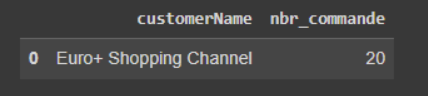

### q4

 pr chaque ligne de production et par mois de l'année le total de quantité commandé ainsi que le chiffre d'affaire. le resultat sera ordonné par product line en ordre ascendant alphabetique et puis par le mois de l'année en descendant

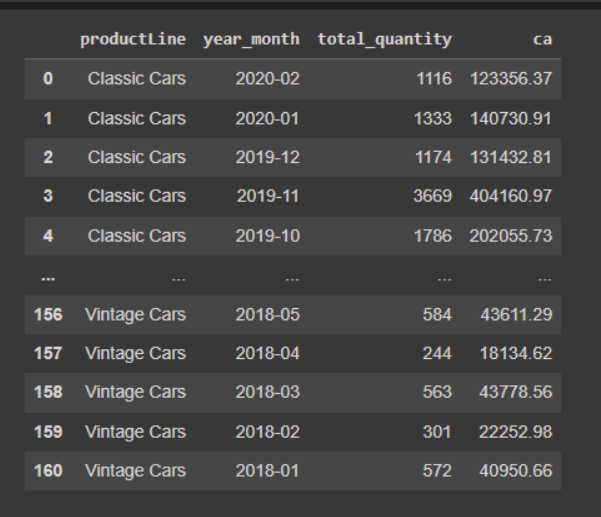

In [ ]:
r = """
      select productLine, strftime("%Y-%m", orderDate) as year_month,
      sum(orderdetails.quantityOrdered) as total, sum(orderdetails.quantityOrdered * orderdetails.priceEach) as CA
      from productlines
      left join products using (productLine)
      left join orderdetails using (productCode)
      left join orders using (orderNumber)
      group by productLine, year_month
      order by productLine asc, year_month desc
      """

df = pd.read_sql(r, conn)
display(df)

,productLine,year_month,total,CA
0,Classic Cars,2020-02,1116.0,123356.37
1,Classic Cars,2020-01,1333.0,140730.91
2,Classic Cars,2019-12,1174.0,131432.81
3,Classic Cars,2019-11,3669.0,404160.97
4,Classic Cars,2019-10,1786.0,202055.73
...,...,...,...,...
157,Vintage Cars,2018-05,584.0,43611.29
158,Vintage Cars,2018-04,244.0,18134.62
159,Vintage Cars,2018-03,563.0,43778.56
160,Vintage Cars,2018-02,301.0,22252.98


### q 5


afficher le nombre de status different

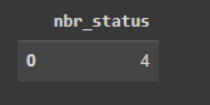

In [ ]:
r = """
        select count(distinct status) as nbr_status
        from orders

    """

df = pd.read_sql(r, conn)
display(df)

,nbr_status
0,4


### q6

nbr de produit par ligne de production. ne selectionner que ceux ayant un total de produit supperieur à 10

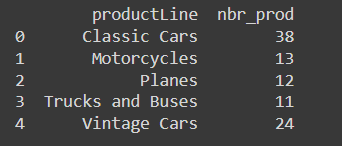

In [ ]:
r = """
        select productLine, count(productCode) as nb_products
        from productlines
        left join products using(productLine)
        group by productLine
        having nb_products > 10
    """

df = pd.read_sql(r, conn)
display(df)

,productLine,nb_products
0,Classic Cars,38
1,Motorcycles,13
2,Planes,12
3,Trucks and Buses,11
4,Vintage Cars,24


### q7

afficher le nbr de produit commandé  et total ca par office .n'include que le top 3 des offices ayant le plus grand ca

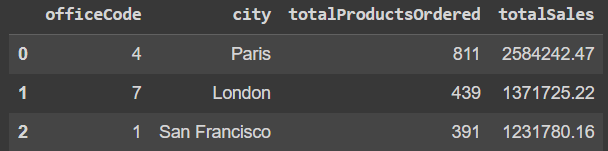

In [ ]:
r = """
      select offices.officeCode, offices.city,
      sum(orderdetails.quantityOrdered) as totalProductsOrdered,
      sum(orderdetails.quantityOrdered * orderdetails.priceEach) as totalSales
      from offices
      left join employees using(officeCode)
      left join customers on employees.employeeNumber = customers.salesRepEmployeeNumber
      left join orders using(customerNumber)
      left join orderdetails using(orderNumber)
      group by offices.officeCode, offices.city
      order by totalSales desc
      limit 3
      """

df = pd.read_sql(r, conn)
display(df)

,officeCode,city,totalProductsOrdered,totalSales
0,4,Paris,28364,2584242.47
1,7,London,15004,1371725.22
2,1,San Francisco,13768,1231780.16


# rgpd

definir c'est quoi la rgpd ? quel interet? (ecrire un text explicatif

est ce que la reglementation rgpd est mondiale ?

quel type de données peuvent etre senible et il faut faire attention à les anonymiser?

est ce que toys and model contient des données sensibles

In [ ]:
# la RGPD est une réglementation qui encadre la collecte et l'utilisation des données personnelles
# elle définit notamment le contexte dans lequel des données peuvent être collectées, stockées, utilisées
# selon l'objectif de l'organisme/entreprise/association/administration qui effectue la collecte, le stockage, et l'utilisation
# une entreprise qui fait de la publicité ciblée ne collectera / ne stockera pas / n'utilisera pas les mêmes données qu'une administration

# cette réglementation se trouve à l'échelle française et européenne

# la sensibilité des données et leur éventuelle anonymisation dépend du contexte dans lequel ces données ont été collectées
# globalement des données personnelles telles que numéro de téléphone, adresse, adresse électronique sont des données sensibles
# l'anonymisation des données devient obligatoire selon le contexte d'utilisation des données, c'est à dire selon l'objectif de l'entreprise qui les a collecté
# si l'objectif est légitime pour l'utilisation des données celles-ci peuvent être utilisées sans anonymiser
# en revanche des données médicales par exemple doivent être anonymisées si par exemple elles entrent dans le cadre d'une étude statistique

# pour le cas toys and models, il y a des données sensibles concernant les customers (adress, phone, ...)
# l'objectif de l'entreprise devra être légitime pour l'utilisation de ces données
# toys and models étant une entreprise commerciale il est logique d'établir un fichier clients

# pandas

In [ ]:
df_house = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/kc_house_data.csv")

In [ ]:
print(df_house.head().to_markdown())

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|
|  0 | 7129300520 | 20141013T000000 |  221900 |          3 |        1    |          1180 |       5650 |        1 |            0 |      0 |           3 |       7 |         1180 |               0 |       1955 |              0 |     98178 | 47.5112 | -122.257 |            1340 |         5650 |
|  1 | 6414100192 | 20141209T000000 |  538000 |          3 |        2.25 |          2570 |       7242 |        2 |          

### exploration de la données

+ afficher quelques lignes, afficher combien de ligne contient le df
+ afficher les type de donne de chaque colone
  + est ce qu'il y a des données dont le type n'est pas normal
+ afficher le nbr de valeur manquante pr chaque colonne
 + supprimer les valeur manquante s'il y en a
+ supprimer doublon
+ afficher les statistiques des colonnes numeriques (rajouter les déciles).
 + est ce qu'il y a des valeur extreme?
+ combien de logement unique dans la base de donnée
+ identifier le nbr de logements avec vue et sans vue sur mer
+ en observant le describe, je remarque qu'il y a une colonne yr_renovated qui contient soit 0 (pr dire non rennové ) soit une année. je veux créer une nouvelle colonne de sorte à avoir 0 si c'est non rénové et 1 si c'est renové

+ dans mon analyse je m'interesse aux apartement contenat au maximum 5 chambresn. extraire les appart avec un nbr de chambre inferieur ou egale à 5 et les enlever du dataframe
+ identifier la moyenne de prix
+ afficher les informations du logement ayant le prix le plus élevé

+ extraire les decenie de year_built et stocker dans nouvelle  colonne (year_decenie)
+ quelle est la moyenne des prix par decenie, trier par order decroissant des moyenne de prix

+ encoder la colonne décenie en get dummies







In [ ]:
#afficher quelques lignes, afficher combien de ligne contient le df

print(df_house.head().to_markdown())
print(df_house.shape)

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|
|  0 | 7129300520 | 20141013T000000 |  221900 |          3 |        1    |          1180 |       5650 |        1 |            0 |      0 |           3 |       7 |         1180 |               0 |       1955 |              0 |     98178 | 47.5112 | -122.257 |            1340 |         5650 |
|  1 | 6414100192 | 20141209T000000 |  538000 |          3 |        2.25 |          2570 |       7242 |        2 |          

le df contient 21613 lignes

In [ ]:
# afficher les type de donne de chaque colone,est ce qu'il y a des données dont le type n'est pas normal

print(df_house.dtypes)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


les données de la colonne date sont en object ce qui n'est pas cohérent, il faudra peut-être les transformer en format datetime

In [ ]:
# afficher le nbr de valeur manquante pr chaque colonne

print(df_house.isna().sum())

id               0
date             0
price            4
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


on trouve 4 valeurs manquantes dans la colonne price

In [ ]:
# supprimer les valeur manquante s'il y en a

df_house = df_house.dropna()
print(df_house.isna().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [ ]:
print(df_house.shape)

(21609, 21)


In [ ]:
# supprimer doublon

df_house.drop_duplicates()
print(df_house.shape)

(21609, 21)


pas de doublons

In [ ]:
# afficher les statistiques des colonnes numeriques (rajouter les déciles). est ce qu'il y a des valeur extreme?

df_house.describe(percentiles = np.arange(0, 1, 0.1))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.160900e+04,2.160900e+04,21609.000000,21609.000000,21609.000000,2.160900e+04,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000,21609.000000
mean,4.580689e+09,5.401174e+05,3.370957,2.114848,2080.009394,1.510927e+04,1.494215,0.007543,0.234347,3.409505,7.656902,1788.446388,291.563006,1970.998149,84.417881,98077.932898,47.560053,-122.213888,1986.675876,12770.270767
std,2.876501e+09,3.671546e+05,0.930041,0.770114,918.462157,4.142399e+04,0.539995,0.086525,0.766382,0.650779,1.175546,828.126031,442.598231,29.371599,401.714775,53.503078,0.138576,0.140832,685.379601,27306.360213
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
0%,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
10%,1.036001e+09,2.450000e+05,2.000000,1.000000,1090.000000,3.325000e+03,1.000000,0.000000,0.000000,3.000000,6.000000,968.600000,0.000000,1926.000000,0.000000,98008.000000,47.350300,-122.372000,1259.200000,3674.400000
20%,1.774001e+09,2.982700e+05,3.000000,1.500000,1320.000000,4.647600e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1120.000000,0.000000,1947.000000,0.000000,98028.000000,47.432160,-122.346000,1420.000000,4800.000000
30%,2.517001e+09,3.450000e+05,3.000000,1.750000,1520.000000,5.612000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1260.000000,0.000000,1956.000000,0.000000,98038.000000,47.496900,-122.312000,1550.000000,5626.000000
40%,3.278602e+09,3.995000e+05,3.000000,2.000000,1710.000000,6.750000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1400.000000,0.000000,1965.000000,0.000000,98053.000000,47.539600,-122.286800,1690.000000,6750.200000
50%,3.904931e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000


il y a des valeurs extrêmes pour les colonnes "bedrooms", "sqft_living", "sqft_above", "sqft_basement", "sqft_living15", "sqft_lot15"

pour la colonne "yr_renovated", les données représentant des dates, on ne peut pas considérer que ce sont des valeurs extrêmes

In [ ]:
# combien de logement unique dans la base de donnée

print(df_house["id"].nunique())

21432


il y a 21432 logements uniques

In [ ]:
# identifier le nbr de logment avec vues et sans vue sur mer

print(df_house["waterfront"].value_counts())

waterfront
0    21446
1      163
Name: count, dtype: int64


il y a 21446 logements qui n'ont pas vue sur la mer (0) et 163 logements avec vue sur mer (1)

In [ ]:
# en observant le describe, je remarque qu'il y a une colonne yr_renovated qui contient soit 0 (pr dire non rennové ) soit une année.
# je veux créer une nouvelle colonne de sorte à avoir 0 si c'est non rénové et 1 si c'est renové

df_house["renovated"] = df_house["yr_renovated"].apply(lambda x: 0 if x == 0 else 1)
print(df_house.head().to_markdown())

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |   renovated |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|------------:|
|  0 | 7129300520 | 20141013T000000 |  221900 |          3 |        1    |          1180 |       5650 |        1 |            0 |      0 |           3 |       7 |         1180 |               0 |       1955 |              0 |     98178 | 47.5112 | -122.257 |            1340 |         5650 |           0 |
|  1 | 6414100192 | 20141209T000000 |  538000 |          3 |        2.25 |        

In [ ]:
# dans mon analyse je m'interesse aux apartement contenant au maximum 5 chambres
# extraire les appart avec un nbr de chambre inferieur ou egale à 5

df_house = df_house[df_house["bedrooms"] <= 5]
print(df_house.shape)

(21275, 22)


In [ ]:
df_house["bedrooms"].value_counts()

,count
bedrooms,
3,9823
4,6881
2,2758
5,1601
1,199
0,13


In [ ]:
# identifier la moyenne de prix

print(round(df_house["price"].mean(), 2))

535246.22


In [ ]:
# afficher les informations du logement ayant le prix le plus élevé

print(df_house.loc[df_house["price"].idxmax()])

id                    9808700762
date             20140611T000000
price                  7062500.0
bedrooms                       5
bathrooms                    4.5
sqft_living                10040
sqft_lot                   37325
floors                       2.0
waterfront                     1
view                           2
condition                      3
grade                         11
sqft_above                  7680
sqft_basement               2360
yr_built                    1940
yr_renovated                2001
zipcode                    98004
lat                        47.65
long                    -122.214
sqft_living15               3930
sqft_lot15                 25449
renovated                      1
Name: 3914, dtype: object


In [ ]:
# extraire les decenie de year_built et stocker dans nouvelle colonne (year_decenie)

def decenie(x):
    return (x // 10) * 10

df_house["year_decenie"] = df_house["yr_built"].apply(decenie)
print(df_house.head().to_markdown())

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |   renovated |   year_decenie |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|------------:|---------------:|
|  0 | 7129300520 | 20141013T000000 |  221900 |          3 |        1    |          1180 |       5650 |        1 |            0 |      0 |           3 |       7 |         1180 |               0 |       1955 |              0 |     98178 | 47.5112 | -122.257 |            1340 |         5650 |           0 |           1950 |
|  1 | 6414100192 | 20141209T00

In [ ]:
# quelle est la moyenne des prix par decenie, trier par order decroissant des moyenne de prix

test = df_house.groupby("year_decenie")["price"].mean()
test2 = test.sort_values(ascending = False)
print(test2.round(2))

year_decenie
2010    629709.67
1900    620288.12
2000    608416.58
1920    595241.72
1930    586423.23
1990    576828.19
1910    562219.55
1980    526390.04
1970    492682.25
1950    477934.85
1960    449523.46
1940    444253.17
Name: price, dtype: float64


In [ ]:
# encoder la colonne décenie en get dummies

df_house = pd.get_dummies(df_house, columns = ["year_decenie"])
print(df_house.head().to_markdown())

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |   renovated | year_decenie_1900   | year_decenie_1910   | year_decenie_1920   | year_decenie_1930   | year_decenie_1940   | year_decenie_1950   | year_decenie_1960   | year_decenie_1970   | year_decenie_1980   | year_decenie_1990   | year_decenie_2000   | year_decenie_2010   |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|------------:|:--------------------|:--------------------|:--------------------|:--------------------|:--------------------|:--------------

# regex

In [ ]:
# executer ce code pr generer de la data
l_text = []
for iter in range(100):
    y = random.choice([1925, 3000, 500, 2001, 2022, 2079, 2000, 1934, 1000, 2006, 20007, 1950," "])
    q = random.randint(10,5000)
    text = f"quantity order {q} for the year {y}"
    l_text.append(text)

df_regex = pd.DataFrame({'indice':list(range(100)), 'text':l_text})

In [ ]:
display(df_regex)

,indice,text
0,0,quantity order 178 for the year 500
1,1,quantity order 1935 for the year 2006
2,2,quantity order 2348 for the year 2006
3,3,quantity order 284 for the year 20007
4,4,quantity order 3212 for the year 2022
...,...,...
95,95,quantity order 1493 for the year 1934
96,96,quantity order 3682 for the year 20007
97,97,quantity order 4842 for the year 2000
98,98,quantity order 2754 for the year 2079


In [ ]:
#je veux utiliser regex pr extraire les année

import re

df_regex["year"] = df_regex["text"].str.extract('year (\d{3,})')
display(df_regex)

# voir avec cette formule: df_regex["year"] = df_regex["text"].str.extract('year (\d{4})')



,indice,text,year
0,0,quantity order 178 for the year 500,500
1,1,quantity order 1935 for the year 2006,2006
2,2,quantity order 2348 for the year 2006,2006
3,3,quantity order 284 for the year 20007,20007
4,4,quantity order 3212 for the year 2022,2022
...,...,...,...
95,95,quantity order 1493 for the year 1934,1934
96,96,quantity order 3682 for the year 20007,20007
97,97,quantity order 4842 for the year 2000,2000
98,98,quantity order 2754 for the year 2079,2079


In [ ]:
df_regex["year_2"] = df_regex["text"].str.extract('year (\d{4})')
display(df_regex)

,indice,text,year,year_2
0,0,quantity order 178 for the year 500,500,NaN
1,1,quantity order 1935 for the year 2006,2006,2006
2,2,quantity order 2348 for the year 2006,2006,2006
3,3,quantity order 284 for the year 20007,20007,2000
4,4,quantity order 3212 for the year 2022,2022,2022
...,...,...,...,...
95,95,quantity order 1493 for the year 1934,1934,1934
96,96,quantity order 3682 for the year 20007,20007,2000
97,97,quantity order 4842 for the year 2000,2000,2000
98,98,quantity order 2754 for the year 2079,2079,2079


# api

trouver l'adresse à partir de la longitude latitude

48.86672    /           2.382091

In [ ]:
url = "https://api-adresse.data.gouv.fr/reverse/?lon=2.382091&lat=48.86672"

In [ ]:
r = requests.get(url)
r_js = r.json()

In [ ]:
print(r_js)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [2.382091, 48.86672]}, 'properties': {'type': 'housenumber', 'name': '156 Rue Oberkampf', 'label': '156 Rue Oberkampf 75011 Paris', 'street': 'Rue Oberkampf', 'postcode': '75011', 'citycode': '75111', 'city': 'Paris', 'oldcitycode': None, 'oldcity': None, 'district': 'Paris 11e Arrondissement', 'context': '75, Paris, Île-de-France', 'importance': 0.7919, 'housenumber': '156', 'id': '75111_6858_00156', 'x': 654670.97, 'y': 6863142.95, 'distance': 0, 'score': 1, '_type': 'address'}}, {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [2.382275, 48.866765]}, 'properties': {'type': 'housenumber', 'name': '158 Rue Oberkampf', 'label': '158 Rue Oberkampf 75011 Paris', 'street': 'Rue Oberkampf', 'postcode': '75011', 'citycode': '75111', 'city': 'Paris', 'oldcitycode': None, 'oldcity': None, 'district': 'Paris 11e Arrondissement', 'context': '75, Paris, Île-de-France', 'imp

In [ ]:
print(r_js["features"][0]["properties"]["label"])

156 Rue Oberkampf 75011 Paris


In [ ]:
# mettre en fonction
# ouvrir l'url sur le browser

# scrum methode agile

decrire brievement avec vos propre mots

+ decrire rapidement la methode scrum et son interet

+ quel different roles dans une equipe scrum

+ quel difference entre product owner et scrum master

+ c'est quoi un sprint


In [ ]:
# la méthode SCRUM est un dérivé de la méthode AGILE qui permet de fluidifier l'organisation d'une équipe lors de la réalisation d'un projet
# elle permet, en attribuant des rôles à chacun et en faisant des retours réguliers sur l'évolution du projet et d'adapter les tâches en fonction de

# la méthode SCRUM comprend un Scrum Master, un Product Owner, et des développeurs

# le Scrum Master a pour rôle de plannifier le projet, de déterminer les tâches à accomplir et d'attribuer les tâches à ses collaborateurs
# il doit donc avoir une vision précise à chaque instant de l'évolution du projet, des avancements comme des diificultés rencontrées
# enfin il doit être en relation permanente avec le product owner pour évaluer les décisions prises

# le Product Owner est la personne qui va être en lien direct avec le client et restranscrire pour son équipe ses avis, décisions, demandes, questions
# d'une certaine manière, il épaule le Scrum Master avec une vision client du projet, là où le Scrum Master aura une vision peut être plus technique

# dans la méthodologie SCRUM, un sprint est une période (généralement 1 semaine) durant laquelle une étape du projet doit être réalisée
# le projet est divisé en un certain nombre de sprints (en fonction de la deadline, de la difficulté technique, ...)
# chaque sprint représente donc une étape du projet tel que plannifier par le scrum master en lien avec le product owner
# chaque sprint peut être révisé en fonction de l'état d'avancement du projet, des difficultés rencontrées et des retours clients

# nlp

en reprenant notre dataset sur house sales. on souhaite l'enrichir avec une colonne contenant du text. chercher un nom de variable texte explicite pr enrichie la base. si vous aviez cette colonne comment l'analyser? que pretraitement effectuer pr la nettoyer ? quel type de graphe pr analyser ce contenu text ajouté. est ce que cette colonne texte peut avoir de l'utilité pour faire des prediction,donner un exemple?

In [ ]:
print(df_house.head().to_markdown())

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |   renovated | year_decenie_1900   | year_decenie_1910   | year_decenie_1920   | year_decenie_1930   | year_decenie_1940   | year_decenie_1950   | year_decenie_1960   | year_decenie_1970   | year_decenie_1980   | year_decenie_1990   | year_decenie_2000   | year_decenie_2010   |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|------------:|:--------------------|:--------------------|:--------------------|:--------------------|:--------------------|:--------------

In [ ]:
# on peut imaginer une colonne description qui présenterait l'appartement

# pour analyser cette colonne composée de chaines de caractères on devra effectuer un pré traitement qui comportera
# - on met le texte en lowercase pour faciliter les étapes suivantes
# - on effectue une tokenisation qui consiste à séparer chaque mot
# - on retire la ponctuation et les stopwords (les mots qui n'apportent rien à l'analyse, attention à bien spécifier la langue utilisée)

# - on applique un stemmer ou un lemmatizer (pour repérer les mots de même racine)
# - on peut calculer la fréquence des mots pour identifier ceux qui reviennent le plus souvent

# en termes de visualisations on peut faire un graphe de distribution si on connait la fréquence des mots
# on peut également faire un wordcloud qui fera appraraitre l'importance des mots de façon graphique

# on peut faire des prédictions à partir d'une colonne de texte à condition d'avoir effectuer le pré traitement du texte
# selon ce que contient la colonne texte on peut par exemple faire une analyse de sentiment (positif, neutre, négatif)

# ml regression

on souhaite predire le prix du logement en   fonction des differente caracteristique du logment

In [ ]:
#reprendre la version nettoyé du dataframe (faite precedment)

print(df_house.head().to_markdown())

|    |         id | date            |   price |   bedrooms |   bathrooms |   sqft_living |   sqft_lot |   floors |   waterfront |   view |   condition |   grade |   sqft_above |   sqft_basement |   yr_built |   yr_renovated |   zipcode |     lat |     long |   sqft_living15 |   sqft_lot15 |   renovated | year_decenie_1900   | year_decenie_1910   | year_decenie_1920   | year_decenie_1930   | year_decenie_1940   | year_decenie_1950   | year_decenie_1960   | year_decenie_1970   | year_decenie_1980   | year_decenie_1990   | year_decenie_2000   | year_decenie_2010   |
|---:|-----------:|:----------------|--------:|-----------:|------------:|--------------:|-----------:|---------:|-------------:|-------:|------------:|--------:|-------------:|----------------:|-----------:|---------------:|----------:|--------:|---------:|----------------:|-------------:|------------:|:--------------------|:--------------------|:--------------------|:--------------------|:--------------------|:--------------

+ pk cette problematique est une problematique de regression

c'est une problématique de régression car la variable "price" (notre y) est une variable continue

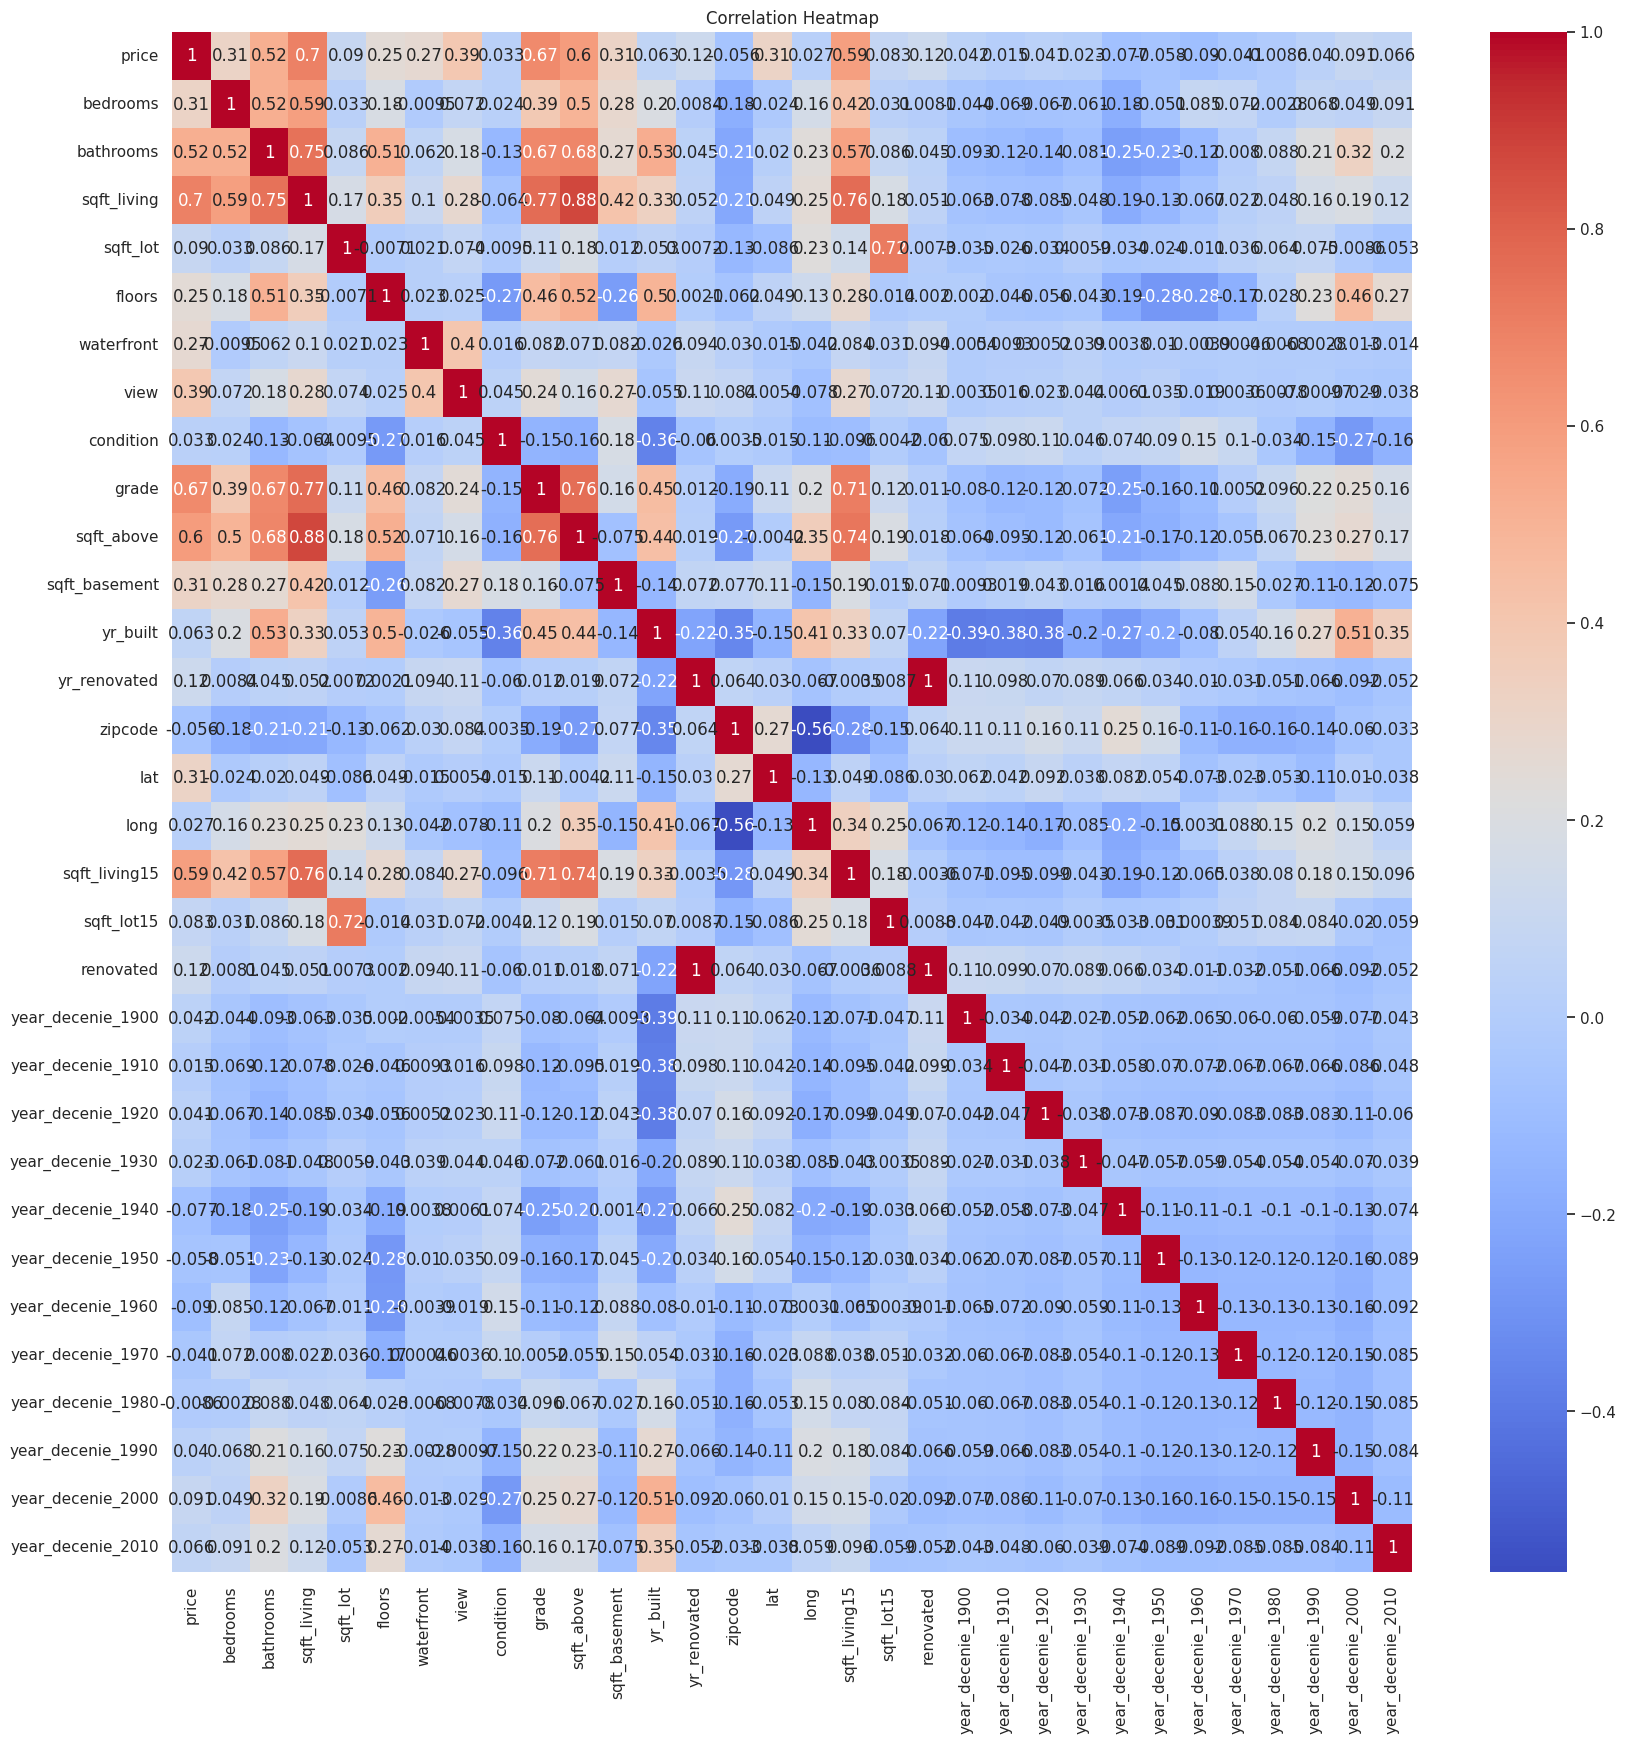

In [ ]:
#definir  le y
y = df_house["price"]

sans_col = ["id", "date"]
data = df_house.loc[:, ~df_house.columns.isin(sans_col)]

#afficher la matrice de correlation, identifier les variables les plus corrélé à y
correlation_matrix = data.corr()

sns.set(rc={"figure.figsize": (20, 20)})
sns.heatmap(correlation_matrix, cmap="coolwarm", annot = True)

plt.title("Correlation Heatmap")

plt.show()


In [ ]:
# definir x  avec les variables les plus correle à y (vous devez inclure dans x la version encodé de  year_decenie)

serie_corr = correlation_matrix['price']

## filtrer sur les colonnes les plus corrélé => on considère un seuil à 0.5 (possible de mettre un seuil à 0.3 selon les résultats de la matrice de corrélation)
seuil = 0.5

condition = (serie_corr >= seuil) | (serie_corr <= -seuil)

selection = serie_corr[condition]

#print(selection)
##colonnes selectionnées
select_col = list(selection.index)
select_col.remove("price")
print(select_col)

['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15']


In [ ]:
# je choisis d'ajouter "waterfront" magré son coefficient de corrélation de 0.3
X = df_house[["bathrooms", "sqft_living",
              "waterfront", "grade",
              "sqft_above", "sqft_living15",
              "year_decenie_1900", "year_decenie_1910", "year_decenie_1920",
              "year_decenie_1930", "year_decenie_1940", "year_decenie_1950",
              "year_decenie_1960", "year_decenie_1970", "year_decenie_1980",
              "year_decenie_1990", "year_decenie_2000", "year_decenie_2010"]]

In [ ]:
#separer les données en train et test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#entrainer model sur les données train
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [ ]:
#predire les données sur le test et le train

y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

In [ ]:
# quel score pour evaluer le model? l'interpreter?
from sklearn import metrics

r2_score_train = metrics.r2_score(y_train, y_pred_train)
r2_score_test = metrics.r2_score(y_test, y_pred_test)

print(r2_score_train)
print(r2_score_test)

0.6497899744060169
0.6425227462962407


est ce qu'on est dans une situation d'overfitting ou d'underfitting ?
+ les r2_score des jeux de train et et de test sont très proches
+ on en déduit qu'il n'y a pas d'overfitting (c'est à dire une situation où le score de test montre que les prédictions sont mauvaises)
+ par contre il y a de grandes chances qu'il y ait de l'underfitting (score de train faible à 0.6597)

expliquer le fonctionnement d'une regression lineaire? quelle formule mathematique pour une regression lineaire simple?
+ une régression linéaire va essayer de trouver une droite qui montre la relation entre une variable dépendante (y) et des variables indépendantes (X)
+ la formule mathématique de la régression linéaire simple est  y = ax + b

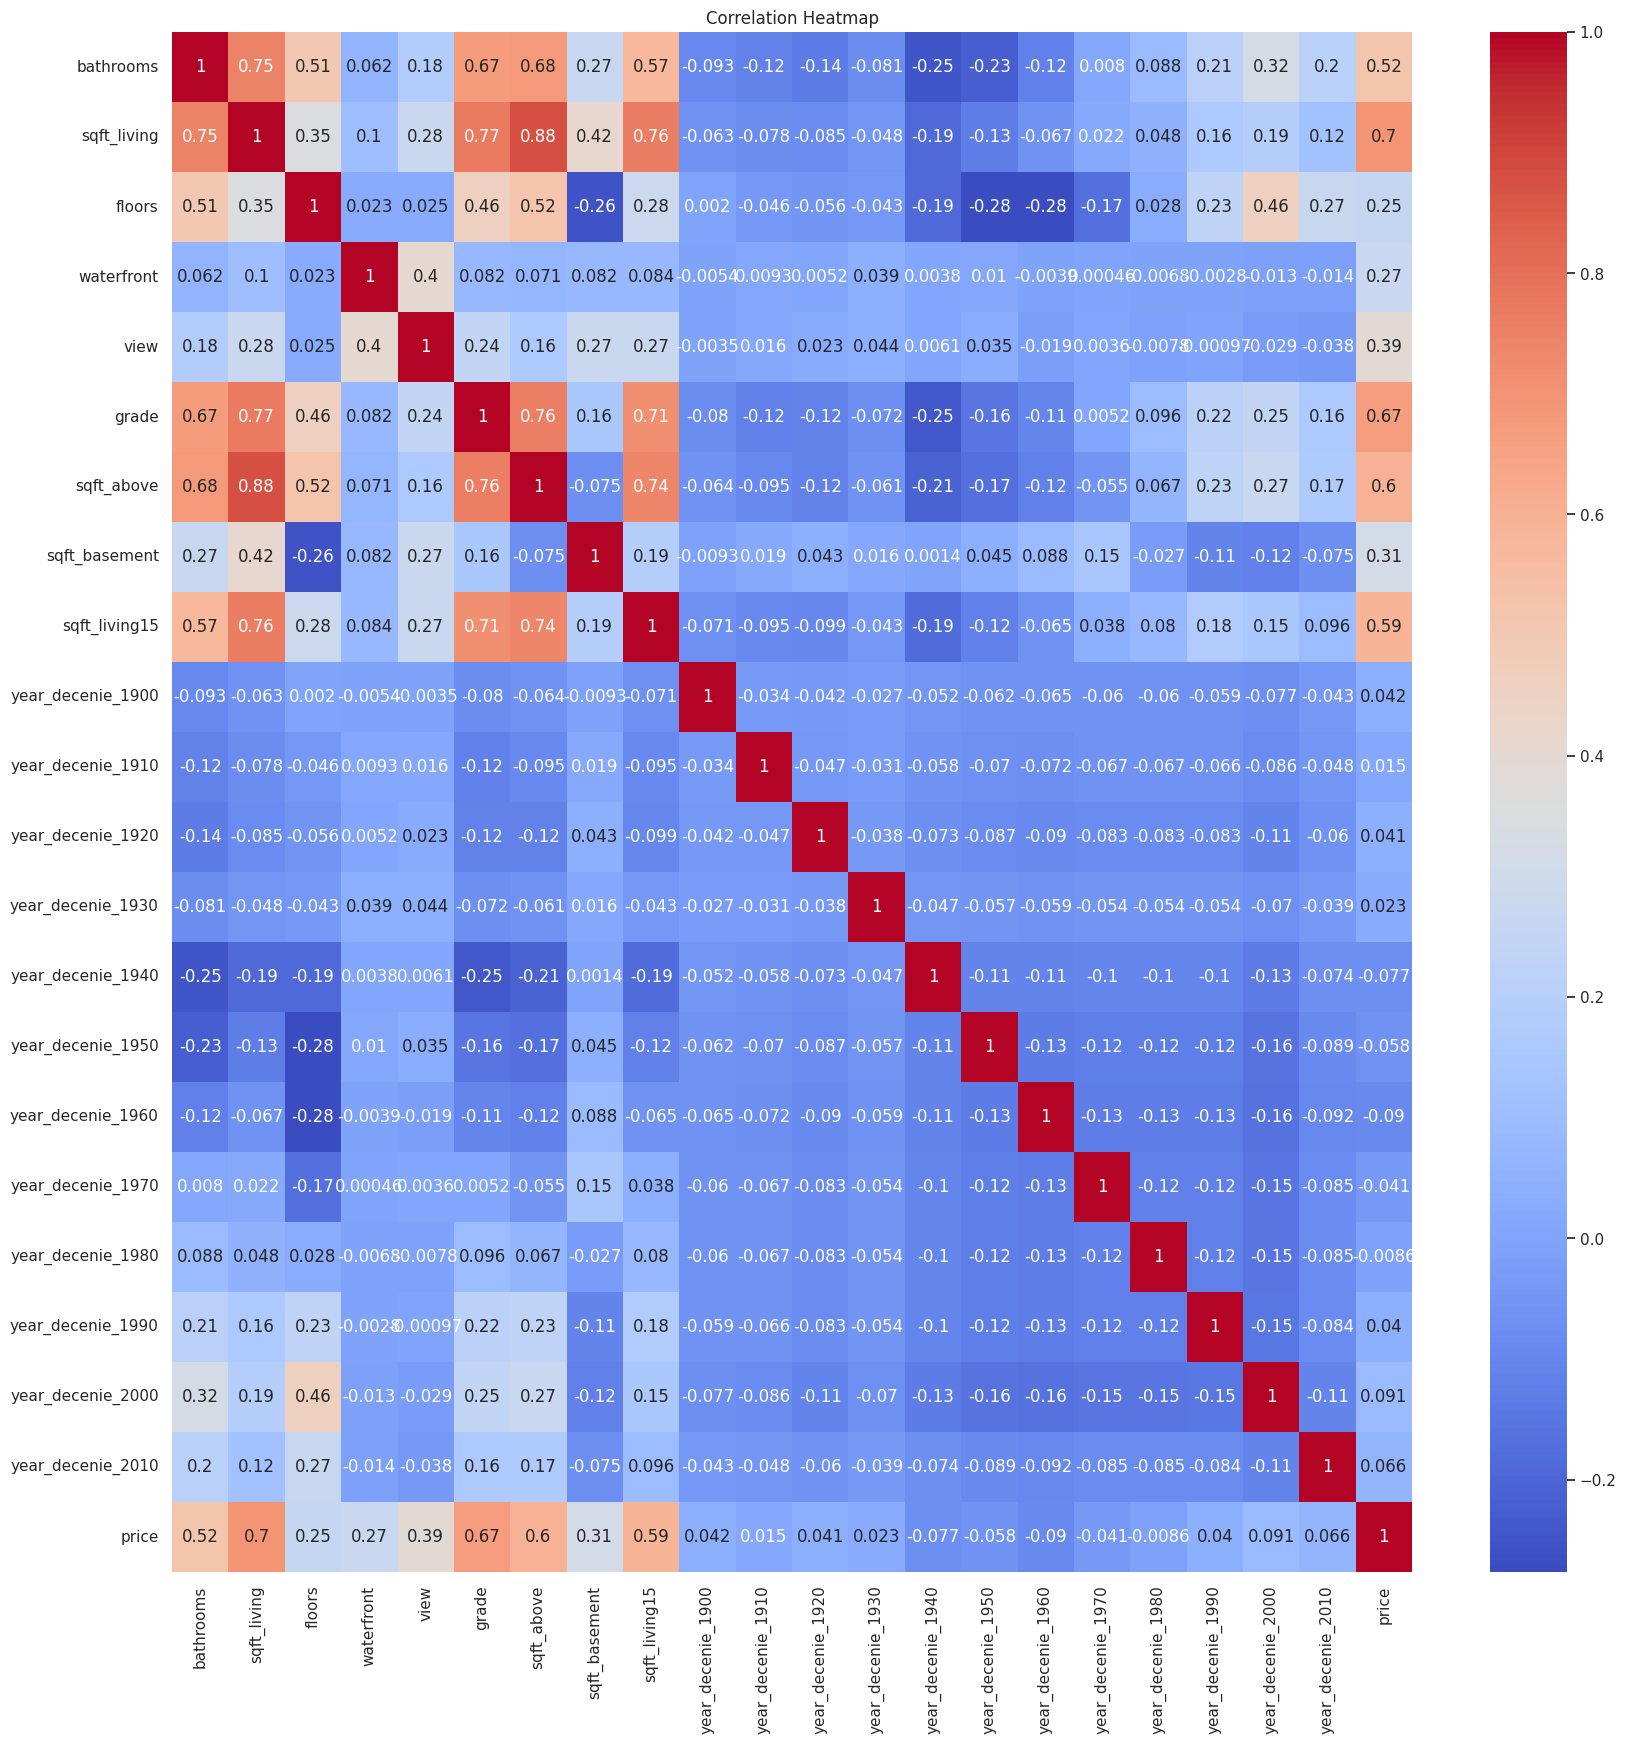

In [ ]:
# correlation
# faire un heatmap? quel est la variable la plus corrélé à y ? comment interpreter ceci

y = y.replace({"Yes" : 1, "No" : 0})
tout = pd.concat([X, y], axis=1)
correlation_matrix = tout.corr()

sns.set(rc={"figure.figsize": (20, 20)})
sns.heatmap(correlation_matrix, cmap="coolwarm", annot = True)

plt.title("Correlation Heatmap")

plt.show()

la variable la plus corrélée à y (price) et sqft_living (score de 0.7)

la surface du living est l'élément le plus déterminant dans l'évaluation du prix

# ml classification

In [ ]:
df_telecom = pd.read_csv("https://raw.githubusercontent.com/murpi/wilddata/master/quests/churn_telecom.csv")

In [ ]:
print(df_telecom.head().to_markdown())

|    | customerID   | gender   |   SeniorCitizen | Partner   | Dependents   |   tenure | PhoneService   | MultipleLines    | InternetService   | OnlineSecurity   | OnlineBackup   | DeviceProtection   | TechSupport   | StreamingTV   | StreamingMovies   | Contract       | PaperlessBilling   | PaymentMethod             |   MonthlyCharges |   TotalCharges | Churn   |
|---:|:-------------|:---------|----------------:|:----------|:-------------|---------:|:---------------|:-----------------|:------------------|:-----------------|:---------------|:-------------------|:--------------|:--------------|:------------------|:---------------|:-------------------|:--------------------------|-----------------:|---------------:|:--------|
|  0 | 7590-VHVEG   | Female   |               0 | Yes       | No           |        1 | No             | No phone service | Fiber optic       | No               | Yes            | No                 | No            | No            | No                | Month-to-month

on souhaite predire si un client est suceptible de se desabonner (colonne churn)



In [ ]:
print(df_telecom.nunique())

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [ ]:
#encoder les données categorielle avec la methode approprié
categorical_data = ["MultipleLines", "InternetService", "OnlineSecurity",
                    "OnlineBackup", "DeviceProtection", "TechSupport",
                    "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]

for c in categorical_data:
  print(f"###### colonne {c} ######")
  print()
  print("------ unique values ------")
  print(df_telecom[c].unique())
  print()

###### colonne MultipleLines ######

------ unique values ------
['No phone service' 'No' 'Yes']

###### colonne InternetService ######

------ unique values ------
['Fiber optic' 'DSL' 'No']

###### colonne OnlineSecurity ######

------ unique values ------
['No' 'Yes' 'No internet service']

###### colonne OnlineBackup ######

------ unique values ------
['Yes' 'No' 'No internet service']

###### colonne DeviceProtection ######

------ unique values ------
['No' 'Yes' 'No internet service']

###### colonne TechSupport ######

------ unique values ------
['No' 'Yes' 'No internet service']

###### colonne StreamingTV ######

------ unique values ------
['No' 'Yes' 'No internet service']

###### colonne StreamingMovies ######

------ unique values ------
['No' 'Yes' 'No internet service']

###### colonne Contract ######

------ unique values ------
['Month-to-month' 'One year' 'Two year']

###### colonne PaymentMethod ######

------ unique values ------
['Electronic check' 'Mailed check

In [ ]:
# je factorise les colonnes où il n' y a que 2 valeurs

df_telecom["gender"] = df_telecom["gender"].factorize()[0]
df_telecom["SeniorCitizen"] = df_telecom["SeniorCitizen"].factorize()[0]
df_telecom["Partner"] = df_telecom["Partner"].factorize()[0]
df_telecom["Dependents"] = df_telecom["Dependents"].factorize()[0]
df_telecom["PhoneService"] = df_telecom["PhoneService"].factorize()[0]
df_telecom["PaperlessBilling"] = df_telecom["PaperlessBilling"].factorize()[0]
df_telecom["Churn"] = df_telecom["Churn"].factorize()[0]

In [ ]:
# pour les colonnes où il y a 3 ou 4 valeurs je fais un get_dummies

df_telecom = pd.get_dummies(df_telecom, columns = ["MultipleLines", "InternetService", "OnlineSecurity",
                    "OnlineBackup", "DeviceProtection", "TechSupport",
                    "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"])

In [ ]:
print(df_telecom.head().to_markdown())

|    | customerID   |   gender |   SeniorCitizen |   Partner |   Dependents |   tenure |   PhoneService |   PaperlessBilling |   MonthlyCharges |   TotalCharges |   Churn | MultipleLines_No   | MultipleLines_No phone service   | MultipleLines_Yes   | InternetService_DSL   | InternetService_Fiber optic   | InternetService_No   | OnlineSecurity_No   | OnlineSecurity_No internet service   | OnlineSecurity_Yes   | OnlineBackup_No   | OnlineBackup_No internet service   | OnlineBackup_Yes   | DeviceProtection_No   | DeviceProtection_No internet service   | DeviceProtection_Yes   | TechSupport_No   | TechSupport_No internet service   | TechSupport_Yes   | StreamingTV_No   | StreamingTV_No internet service   | StreamingTV_Yes   | StreamingMovies_No   | StreamingMovies_No internet service   | StreamingMovies_Yes   | Contract_Month-to-month   | Contract_One year   | Contract_Two year   | PaymentMethod_Bank transfer (automatic)   | PaymentMethod_Credit card (automatic)   | PaymentMethod_Electroni

In [ ]:
# verifier les type de colonne?
print(df_telecom.dtypes)

customerID                                  object
gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                                object
Churn                                        int64
MultipleLines_No                              bool
MultipleLines_No phone service                bool
MultipleLines_Yes                             bool
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No                            bool
OnlineSecurity_No                             bool
OnlineSecurity_No internet service            bool
OnlineSecurity_Yes             

In [ ]:
# pk la colonne total charge est en object? la transformer en float
pd.to_numeric(df_telecom["TotalCharges"], errors='coerce')

,TotalCharges
0,29.85
1,1889.50
2,108.15
3,1840.75
4,151.65
...,...
7038,1990.50
7039,7362.90
7040,346.45
7041,306.60


In [ ]:
#verifier s'il y a des nan dans le df, les traiter

In [ ]:
df_telecom.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
PaperlessBilling,0
MonthlyCharges,0
TotalCharges,0


pas de nan

In [ ]:
# Identifier les lignes contenant ' ' dans n'importe quelle colonne
mask = df_telecom.map(lambda x: isinstance(x, str) and x == ' ')

# Afficher les lignes correspondantes
rows_with_spaces = df_telecom[mask.any(axis=1)]
print(rows_with_spaces.value_counts())

customerID  gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  Churn  MultipleLines_No  MultipleLines_No phone service  MultipleLines_Yes  InternetService_DSL  InternetService_Fiber optic  InternetService_No  OnlineSecurity_No  OnlineSecurity_No internet service  OnlineSecurity_Yes  OnlineBackup_No  OnlineBackup_No internet service  OnlineBackup_Yes  DeviceProtection_No  DeviceProtection_No internet service  DeviceProtection_Yes  TechSupport_No  TechSupport_No internet service  TechSupport_Yes  StreamingTV_No  StreamingTV_No internet service  StreamingTV_Yes  StreamingMovies_No  StreamingMovies_No internet service  StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  Contract_Two year  PaymentMethod_Bank transfer (automatic)  PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  PaymentMethod_Mailed check
1371-DWPAZ  0       0              0        1           0       0             1            

On remarque que la colonne TotalCharges contient des valeurs nulles mais non identifiées comme Nan

In [ ]:
# Supprimer les lignes contenant ' '
df_telecom = df_telecom[~(df_telecom == ' ').any(axis=1)]  # Garder uniquement les lignes sans ' '

In [ ]:
df_telecom.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
      

In [ ]:
# definir x  avec les variables les plus correle à y

#definir  le y
y = df_telecom["Churn"]

sans_col = ["customerID"]
data = df_telecom.loc[:, ~df_telecom.columns.isin(sans_col)]

#afficher la matrice de correlation, identifier les variables les plus corrélé à y
correlation_matrix = data.corr()

serie_corr = correlation_matrix['Churn']

## filtrer sur les colonnes les plus corrélé => on considère un seuil à 0.5 (possible de mettre un seuil à 0.3 selon les résultats de la matrice de corrélation)
seuil = 0.3

condition = (serie_corr >= seuil) | (serie_corr <= -seuil)

selection = serie_corr[condition]

#print(selection)
##colonnes selectionnées
select_col = list(selection.index)
select_col.remove("Churn")
print(select_col)

['tenure', 'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'TechSupport_No', 'Contract_Month-to-month', 'Contract_Two year']


In [ ]:
#definir X et y

X = df_telecom.drop(columns = ["customerID", "MonthlyCharges", "TotalCharges", "Churn"])
y = df_telecom["Churn"]

In [ ]:
#separer données en train et test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##Regression Logistique

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Créer le modèle de régression logistique
log_reg = LogisticRegression()

In [ ]:
# Entraîner le modèle sur les données d'entraînement
log_reg.fit(X_train_scaled, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = log_reg.predict(X_test)

# Afficher les coefficients
print(f"Coefficient : {log_reg.coef_[0]}")
print(f"Intercept : {log_reg.intercept_}")



Coefficient : [ 0.05083669 -0.38361547  0.04702699  0.31972248  3.26467944 -0.34209971
  0.11794783 -0.0216252   0.46283912 -0.32047452 -1.71472877  1.69452053
  0.14094764 -0.36879191  0.14094764  0.34858367  0.07373471  0.14094764
 -0.09394295  0.09978277  0.14094764 -0.11999101 -0.35725409  0.14094764
  0.33704585  0.16256397  0.14094764 -0.18277221  0.28187352  0.14094764
 -0.30208176 -0.8345741   0.24776571  0.70754779  0.23059699  0.19880238
 -0.29399213 -0.01466783]
Intercept : [0.15050015]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy : {accuracy}")


Accuracy : 0.7059158134243458


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix :")
print(conf_matrix)

Confusion Matrix :
[[  22  517]
 [   0 1219]]


##KNN Classifier

In [ ]:
#choisir un model de classification et l'entrainer sur les données

from sklearn.neighbors import KNeighborsClassifier

modelKNN = KNeighborsClassifier(n_neighbors=5)
modelKNN.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [ ]:
#determiner score sur train et test

from sklearn.metrics import accuracy_score

y_pred_train = modelKNN.predict(X_train_scaled)
y_pred_test = modelKNN.predict(X_test_scaled)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

In [ ]:
print(f"Accuracy Score Train : {accuracy_train}")
print(f"Accuracy Score Test : {accuracy_test}")

Accuracy Score Train : 0.8835798255593478
Accuracy Score Test : 0.8339021615472128


comment interpreter ce score ?

les scores sur train et test sont relativement bons ce qui signifie que dans les 2 cas on peut estimer la justesse de leurs prédictions
+ à 88% sur le jeu train
+ à 83% sr le jeu test

est ce qu'il y a overfitting ?

il semble qu'il y ait un léger overfitting ce qui signifie que le modèle a du mal à prédire correctement sur des données qu'il ne connait pas

en utilisant la separation en train et test avec la methode de  train test split, on risque d'avoir des scores qui varient en fct de l'echantillon? quelle solution à ce probleme?

il est possible lors de la phase train_test_split de modifier la taille des échantillons via les paramètres train_size ou test_size

on peut également utiliser une méthode de cross validation qui va tester le modèle sur différents chunks du train set

In [ ]:
#afficher la matrices de confusion, identifier les bonne prediction et les erreurs

from sklearn.metrics import confusion_matrix

# Générer la matrice de confusion
cm = confusion_matrix(y_true=y_test, y_pred=modelKNN.predict(X_test))

# Créer un DataFrame avec des étiquettes corrigées
labels = [str(cls) for cls in modelKNN.classes_]  # Conversion en str
conf_matrix_df = pd.DataFrame(data=cm,
                              index=[label + " ACTUAL" for label in labels],
                              columns=[label + " PREDICTED" for label in labels])

# Afficher la matrice de confusion
print(conf_matrix_df)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


          0 PREDICTED  1 PREDICTED
0 ACTUAL          178          361
1 ACTUAL           22         1197


pour savoir si un client va se réabonner

le modèle prédit correctement
+ 1197 cas où le client se réabonne effectivement et se trompe sur 361 cas
+ 22 cas où le client ne se réabonne pas et se trompe sur 178 cas

quels sont les formules des metriques recall et precision? comment les interprerter

In [ ]:
# formule de recall: TP / (TP + FN)
# ce score nous montre combien de cas réellement positifs le modèle a réussi à identifier

1197 / (1197 + 361)

0.7682926829268293

In [ ]:
# formule de précision : TP / (TP + FP)
# ce score nous montre combien de prédictions sont réellement correctes parmi toutes les prédictions positives faites par le modèle

1197 / (1197+ 22)

0.9819524200164069

In [ ]:
from sklearn.metrics import precision_score, recall_score, classification_report

precision = precision_score(y_test, y_pred)
print(f"Precision : {precision}")

recall = recall_score(y_test, y_pred)
print(f"Recall : {recall}")

print(classification_report(y_test, y_pred))

Precision : 0.7021889400921659
Recall : 1.0
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       539
           1       0.70      1.00      0.83      1219

    accuracy                           0.71      1758
   macro avg       0.85      0.52      0.45      1758
weighted avg       0.79      0.71      0.60      1758



In [ ]:
df_telecom["Churn"].value_counts()

,count
Churn,
1,4822
0,2210


les classes pour la colonne Churn sont déséquilibrées ce qui explique la difficulté du modèle à prédire pour la classe 0 (f1_score à 0.08) et à bien prédire pour la classe 1 (f1_score à 0.83)

##J'essaye un arbre de décision

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelDT = DecisionTreeClassifier()
modelDT.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_train = modelDT.predict(X_train_scaled)
y_pred_test = modelDT.predict(X_test_scaled)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

In [ ]:
print(f"Accuracy Score Train : {accuracy_train}")
print(f"Accuracy Score Test : {accuracy_test}")

Accuracy Score Train : 0.9878649981039059
Accuracy Score Test : 0.8128555176336746


les scores de l'arbre de décision nous montrent qu'il y a un overfitting

on en déduit que ce modèle ne parvient pas à faire de bonnes prédictions sur les données qu'il ne connait pas

# web scrapping

+ est ce que le web scrapping est interdit?


+ un collégue à vous souhaite scapper un site, il a besoin de vous pour l'aider à identifier les differentes etapes

In [ ]:
# le web scraping n'est pas interdit mais il faut être très attentif à l'usage qui est fait des données collectées
# la connaissance du RGPD permet d'identifier les types de données qu'on peut collecter et l'usage qu'il est permis d'en faire


# les différentes étapes pour scraper un site:
#   importer les librairies nécessaires : pandas, requests, BeautifulSoup
#   requests permet de vérifier la possibilité de scraper le site (réponse 200 = OK, autre réponse = pas OK)
#   si réponse 200, récupérer l'url et la stocker dans une variable (ex: r = requests.get(url))
#   récupérer le contenu de l'url sous format json (ex: r_json = r.json())
#   transformer le contenu json en dataframe (ex: df = pd.DataFrame(r_js["data"]))
#   la librairie BeautifulSoup va permettre d'extraire les données que l'on souhaite collecter
#   pour cela il faut identifier dans le code html de la page web les balises qui contiennent l'information